NY Rental Analysis

In [38]:
# Dependencies and set up
import os
import csv

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

In [39]:
# Set path for file
import csv
csv_file = os.path.join("NY Realstate Pricing.csv")
realestate_data_df = pd.read_csv(csv_file)

# Display sample data
realestate_data_df.head()

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [40]:
#checking the number of neighbourhoods in NY
realestate_data_df["neighbourhood"].value_counts()

Brooklyn              3875
Manhattan             3229
Queens                1099
Bedford-Stuyvesant     799
Harlem                 632
                      ... 
Sea Gate                 1
Marble Hill              1
Midland Beach            1
Mill Basin               1
Van Nest                 1
Name: neighbourhood, Length: 186, dtype: int64

In [41]:
#clean data
realestate_data_clean_df = realestate_data_df.dropna() 


# Drop any rows with null values
#perferred_cities = perferred_cities.dropna()

# Display sample data
realestate_data_clean_df.head()

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [42]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the days_occuppied_in_2019 for each room type
daysoccupied = realestate_data_clean_df.groupby(["room_type"])
# Use groupby and summary statistical methods to calculate the following properties of each room type: 
# mean, median, variance, standard deviation, and SEM of the occupancy rate. 
# Assemble the resulting series into a single summary DataFrame.
daysoccupied_mean = daysoccupied["days_occupied_in_2019"].mean()
daysoccupied_median = daysoccupied["days_occupied_in_2019"].median()
daysoccupied_var = daysoccupied["days_occupied_in_2019"].var()
daysoccupied_std = daysoccupied["days_occupied_in_2019"].std()
daysoccupied_sem = daysoccupied["days_occupied_in_2019"].sem()

daysoccupied_df = pd.DataFrame({
                        "Mean": daysoccupied_mean,
                        "Median" : daysoccupied_median,
                        "Variance": daysoccupied_var,
                        "Standard Deviation": daysoccupied_std,
                        "SEM": daysoccupied_sem,
})

daysoccupied_df

,Mean,Median,Variance,Standard Deviation,SEM
room_type,,,,,
Entire home/apt,185.165231,200.0,16986.175375,130.331022,1.343904
Hotel room,83.500000,14.5,13106.878788,114.485278,11.448528
Private room,175.723297,198.0,16689.546055,129.188026,1.467288
Shared room,140.022409,83.0,17693.482642,133.016851,7.039998


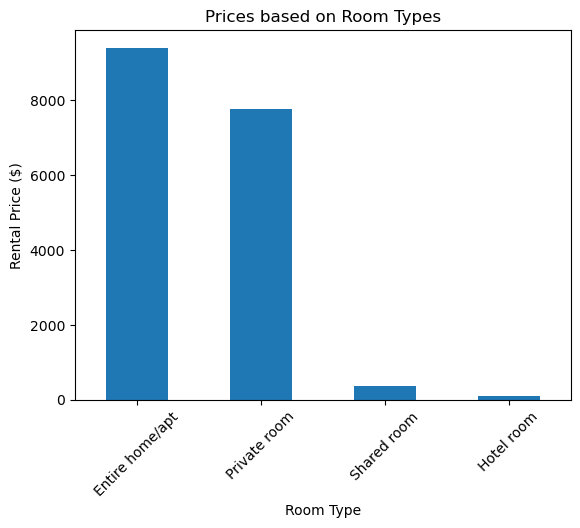

In [43]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.
timepoint = realestate_data_df.groupby(["room_type"])["price"].count()
ax = timepoint.sort_values(ascending=False).plot.bar()
ax = timepoint.sort_values(ascending=False).plot.bar(align='center')

# Set the title, x-label, and y-label of the plot
ax.set_title("Prices based on Room Types")
ax.set_xlabel("Room Type")
ax.set_ylabel("Rental Price ($)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()


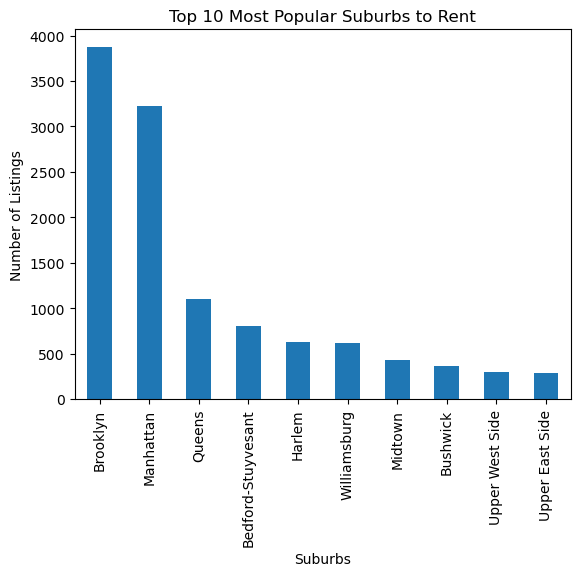

In [44]:
location_count = realestate_data_df['neighbourhood'].value_counts()
top_10_locations = location_count.nlargest(10)
ax = top_10_locations.plot(kind='bar')

ax.set_title("Top 10 Most Popular Suburbs to Rent")
ax.set_xlabel("Suburbs")
ax.set_ylabel("Number of Listings")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

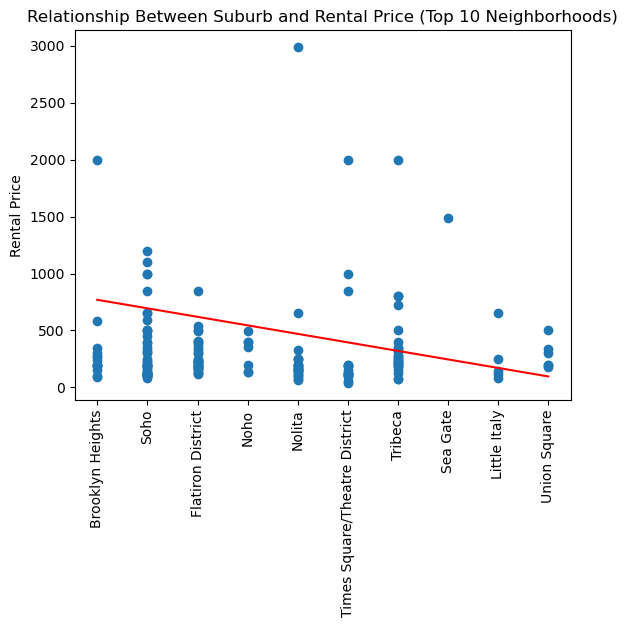

In [45]:
# Get the mean rental price by neighbourhood and select the top 10
rent_and_suburb = realestate_data_df[["price", "neighbourhood"]]
mean_rent_by_suburb = rent_and_suburb.groupby('neighbourhood').mean()
top_10_neighborhoods = mean_rent_by_suburb.sort_values(by='price', ascending=False).head(10).index.tolist()

# Filter the dataset to only include the top 10 neighborhoods
realestate_data_top10_df = realestate_data_df[realestate_data_df['neighbourhood'].isin(top_10_neighborhoods)]

# Create a scatter plot of rental price vs. neighbourhood
plt.scatter(realestate_data_top10_df['neighbourhood'], realestate_data_top10_df['price'])

# Create a linear regression line using numpy's polyfit function
x = np.arange(len(top_10_neighborhoods))
y = mean_rent_by_suburb.loc[top_10_neighborhoods]['price']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

# Set the title and labels of the plot
plt.title("Relationship Between Suburb and Rental Price (Top 10 Neighborhoods)")
#plt.xlabel("Suburb")
plt.ylabel("Rental Price")

# Rotate the x-axis labels to 45 degrees for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

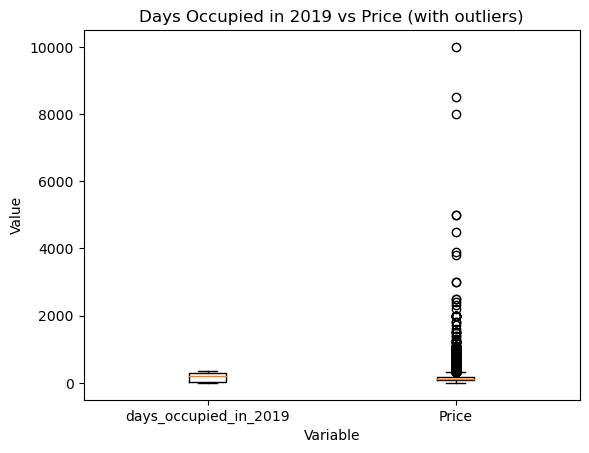

In [46]:
# Filter the data to include only listings from 2019
#realestate_data_2019 = realestate_data_df[realestate_data_df['days_occupied_in_2019'] == 2019]

# Create a list of days occupied in 2019 and a list of prices
days_occupied_2019 = realestate_data_df['days_occupied_in_2019'].tolist()
prices = realestate_data_df['price'].tolist()

# Create the box plot with outliers
plt.boxplot([days_occupied_2019, prices], labels=['days_occupied_in_2019', 'Price'], showfliers=True)

# Set the title and labels of the plot
plt.title('Days Occupied in 2019 vs Price (with outliers)')
plt.xlabel('Variable')
plt.ylabel('Value')

# Display the plot
plt.show()



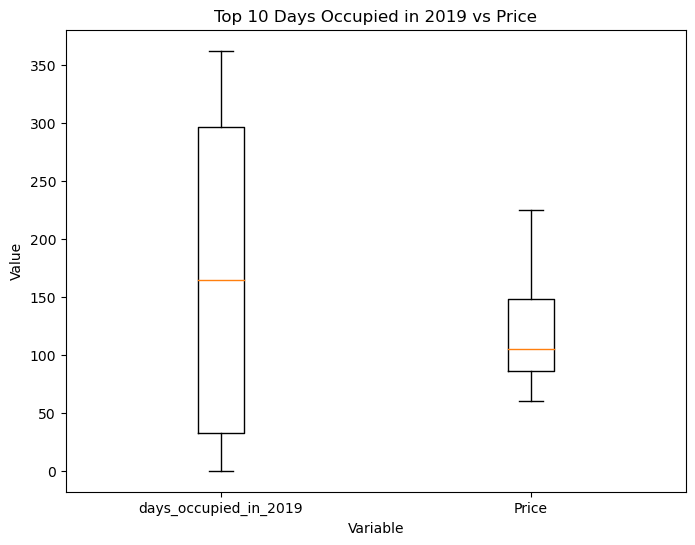

In [47]:
# Create the box plot with outliers and adjust figure size
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot([days_occupied_2019[:10], prices[:10]], labels=['days_occupied_in_2019', 'Price'], showfliers=True)

# Set the title and labels of the plot
ax.set_title('Top 10 Days Occupied in 2019 vs Price')
ax.set_xlabel('Variable')
ax.set_ylabel('Value')

# Display the plot
plt.show()

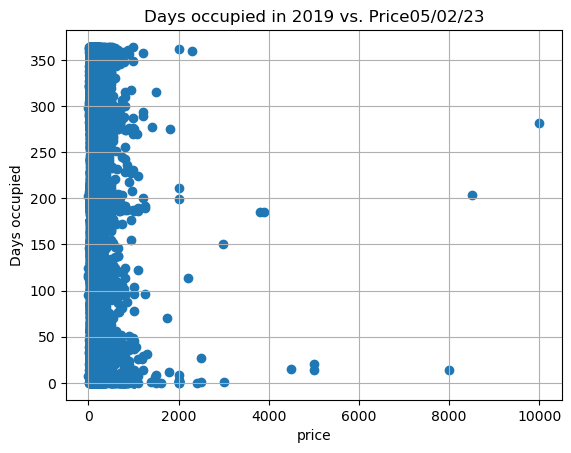

In [49]:
# Build scatter plot for days_occupied_2019 vs. price
x_values = realestate_data_clean_df['price']
y_values = realestate_data_clean_df['days_occupied_in_2019']
plt.scatter(x_values,y_values)

# Incorporate the other graph properties
plt.title(f"Days occupied in 2019 vs. Price" + time.strftime("%x"))
plt.ylabel("Days occupied")
plt.xlabel("price")
plt.grid(True)

# Save the figure
#plt.savefig("output/Fig1.png")

# Show plot
plt.show()